In [ ]:
%load_ext autoreload
%autoreload 2
import pyreadstat
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pandas as pd
from scipy.stats import norm, bernoulli
from utils import make_ess_coverage_plot_intro
import warnings; warnings.simplefilter('ignore')
from utils_optimization import MinMaxOptimizer_l2, constraint_cross_validation
from tqdm import tqdm
import torch
from training import SimpleNN, train_nn

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data, meta = pyreadstat.read_sav("data/pew/ATPW79.sav")
data_sampled = data.sample(frac=0.9)

# Optional: Reset the index of the sampled data
data_sampled = data_sampled.reset_index(drop=True)

In [4]:
question = "ELECTBIDENMSSG_W79" # can choose ELECTBIDENMSSG_W79 or ELECTTRUMPMSSG_W79 
idx_keep = np.where(data_sampled[question] != 99)[0]
Y_all = data_sampled[question].to_numpy()[idx_keep] < 2.5
X_all = data_sampled[['F_PARTYSUM_FINAL', 'COVIDFOL_W79','COVIDTHREAT_a_W79','COVIDTHREAT_b_W79','COVIDTHREAT_c_W79', 'COVIDTHREAT_d_W79','COVIDMASK1_W79', 'COVID_SCI6E_W79', 'F_EDUCCAT', 'F_AGECAT']].to_numpy()[idx_keep]
Y_all = Y_all[(1-(X_all > 50).sum(axis=1).astype(bool)).astype(bool)]
                              
X_all = X_all[(1-(X_all > 50).sum(axis=1).astype(bool)).astype(bool)]

theta_true = np.mean(Y_all)
X_train, X, y_train, Y = train_test_split(X_all, Y_all*1, test_size= 5/9)

In [5]:
dtrain = xgb.DMatrix(X_train, label=y_train)
tree = xgb.train({'eta': 0.001, 'max_depth': 5, 'objective': 'reg:logistic'}, dtrain, 3000)

In [ ]:
p = 0.2

X_bi, X_rem, label, Y_rem = train_test_split(X, Y, test_size=(1 - p))
Yhat = tree.predict(xgb.DMatrix(X_rem))

# burn-in period
error_bi = np.abs(label - tree.predict(xgb.DMatrix(X_bi)))
X_bi_tensor = torch.tensor(X_bi, dtype=torch.float32)
error_bi_tensor = torch.tensor(error_bi, dtype=torch.float32).view(-1,1)
loader = [(X_bi_tensor, error_bi_tensor)]
nn_ = SimpleNN(X_bi_tensor.shape[1])
train_nn(nn_, loader, epochs=1000, lr=0.01)

X_rem_tensor = torch.tensor(X_rem, dtype=torch.float32).to(device)
uncertainty = np.abs(nn_(X_rem_tensor).cpu().detach().numpy().flatten())
uncertainty = np.clip(uncertainty, 0, 1)

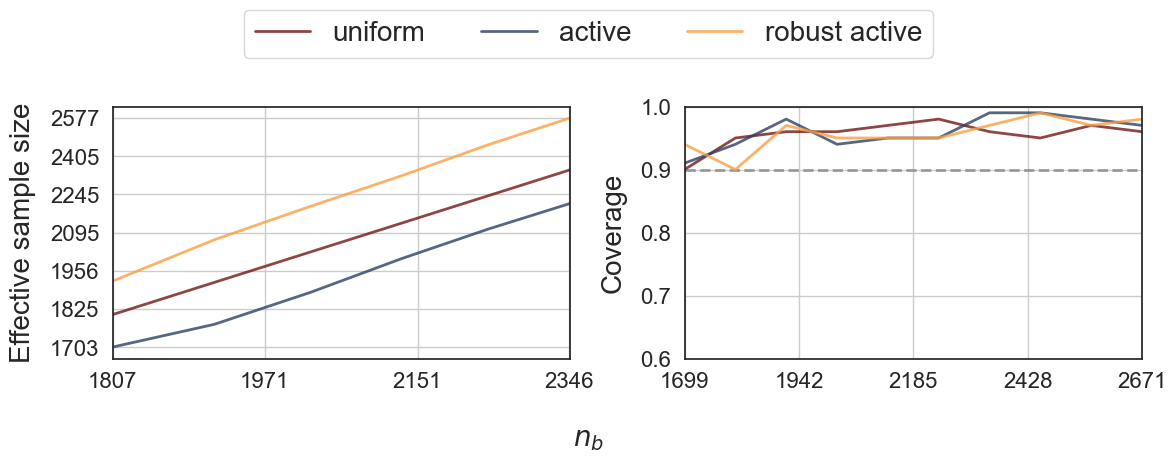

In [ ]:
num_trials = 500
budgets = np.linspace(0.1, 0.3, 10)
alpha = 0.1
n = len(Y)
n_rem = len(Y_rem)

cv_list = [0.02, 0.03, 0.04, 0.05, 0.06, 0.07]
k = 5 
c_list = constraint_cross_validation(X_bi, label, tree, cv_list, k, budgets, device)
tau_list = []
error = uncertainty.copy()
n_rem = len(error)
for i in range(len(budgets)):
    constraint_sum = c_list[i] * np.sqrt(n_rem)
    bg = budgets[i]
    eta = bg / np.mean(uncertainty)
    pi = np.clip(eta*uncertainty, 0.0, 1.0)
    nb = bg * n_rem
    optimizer = MinMaxOptimizer_l2(error, pi, nb, n_rem, constraint_sum)
    optimal_value, optimal_r= optimizer.optimize()
    tau_list.append(optimal_r)
results = []
columns = ["lb", "ub", "interval width", "coverage", "estimator","$n_b$"]
temp_df = pd.DataFrame(np.zeros((3,len(columns))), columns=columns)

for j in range(len(budgets)):
    bg = budgets[j]
    tau = 0.01
    eta = bg / np.mean(uncertainty)
    probs_active = np.clip((1-tau)*eta*uncertainty + tau*bg, 0.0, 1.0)

    tau = tau_list[j]
    probs_robust_active = np.clip((eta * uncertainty) ** (1-tau) * bg ** tau / np.sum((eta * uncertainty) ** (1-tau) * bg ** tau) * bg * n_rem, 0.0, 1.0)

    for i in range(num_trials):
        xi_unif = bernoulli.rvs([bg]*n_rem)
        unif_label = label
        unif_label = np.concatenate((Yhat + (Y_rem - Yhat)*xi_unif/bg, unif_label))
        pointest_unif = np.mean(unif_label)
        pointest_unif_std = np.std(unif_label)/np.sqrt(n)
        width_unif = norm.ppf(1-alpha/2)*pointest_unif_std
        coverage_unif = (theta_true >= pointest_unif - width_unif)*(theta_true <= pointest_unif + width_unif)
        temp_df.loc[0] = pointest_unif - width_unif, pointest_unif + width_unif, 2*width_unif, coverage_unif, "uniform", int(n - (1 - bg) * n_rem)

        xi = bernoulli.rvs(probs_active)
        active_label = label
        active_label = np.concatenate((Yhat + (Y_rem - Yhat)*xi/probs_active, active_label))
        pointest_active = np.mean(active_label)
        pointest_active_std = np.std(active_label)/np.sqrt(n)
        width_active = norm.ppf(1-alpha/2)*pointest_active_std 
        coverage_active = (theta_true >= pointest_active - width_active)*(theta_true <= pointest_active + width_active)   
        temp_df.loc[1] = pointest_active - width_active, pointest_active + width_active, 2*width_active, coverage_active, "active", int(n - (1 - bg) * n_rem)

        xi = bernoulli.rvs(probs_robust_active)
        active_robust_label = label
        active_robust_label = np.concatenate((Yhat + (Y_rem - Yhat)*xi/probs_robust_active, active_robust_label))
        pointest_active_robust = np.mean(active_robust_label)
        pointest_active_robust_std = np.std(active_robust_label)/np.sqrt(n)
        width_active_robust = norm.ppf(1-alpha/2)*pointest_active_robust_std 
        coverage_active_robust = (theta_true >= pointest_active_robust - width_active_robust)*(theta_true <= pointest_active_robust + width_active_robust)   
        temp_df.loc[2] = pointest_active_robust - width_active_robust, pointest_active_robust + width_active_robust, 2*width_active_robust, coverage_active_robust, "robust active", int(n - (1 - bg) * n_rem)  
        
        results += [temp_df.copy()]
df = pd.concat(results,ignore_index=True)

make_ess_coverage_plot_intro(df, "approval rate", "ess_and_coverage_pew79_biden.pdf", theta_true)